# Drift-Diffusion and other Modeling
Here we give a script where we model our experiment, crossing different models of self-initiated action (classic, stochastic accumulation, pink-noise accumulation, and linear ballistic accumulation) with two simple but distinct metacognitive models (single-stage or 2nd threshold and dual-stage or slope-based). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter
from scipy.stats import linregress

import colorednoise as cn

from sklearn.linear_model import LogisticRegression

from scipy.spatial import KDTree
from scipy.ndimage.interpolation import shift

import statsmodels.api as sm


from utils import *

savepath = './figures/'


### Simulate trials of a stochastic accumulator (or other process)

In [2]:
# Simulation basics
n_sims = 1000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)

slopes = np.random.rand(n_sims,)*0.12 + 0.02 # slope

# White Noise, uncomment for stochastic accumulator
noise = np.random.randn(n_sims,tsteps) # white noise

# Pink noise, uncomment for pink-noise accumulation
# noise = cn.powerlaw_psd_gaussian(1.5, (n_sims,tsteps))


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
B = 0.298 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment




for tt in range(tsteps-1):
    
    
    # For stochastic accumulators
    deltaX = (I - k * X[:,tt])*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    # For LBA
#     deltaX =  slopes*dt + c * noise[:,tt] * np.sqrt(dt) 

    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt]) >= B:
        X[np.where(X[:,tt]>=B),tt+1] = B
    
    
# X[np.where(X >=B)[0]] = B

### Sift through the simulated data, align to the threshold-crossings (if the threshold crossing is past 3000 timepoints in)

In [3]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
            backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
            backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

### Plot individual trials from the accumulator

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\1643886733.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\1643886733.py:13: RuntimeWarning: Mean of empty slice
  backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1


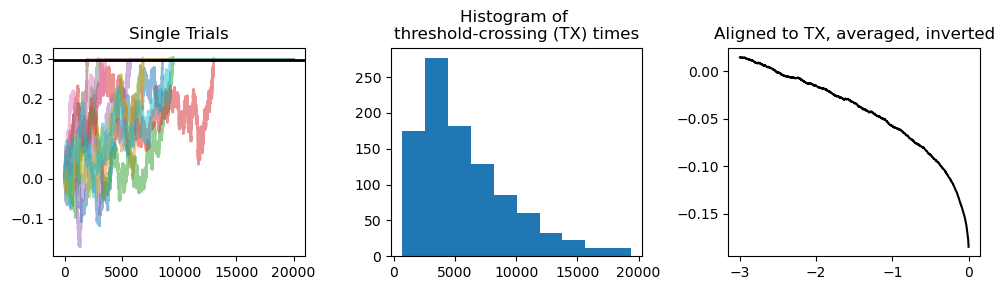

In [4]:
fig,ax = plt.subplots(1,3,figsize=(10,3))


ax[0].plot(np.arange(tsteps),X[:10,:].T,lw=2,alpha=0.5)
ax[0].axhline(B,color='k',lw=2)
ax[0].set_title('Single Trials')


ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')

fig.tight_layout()

# plt.savefig(savepath+'modeling/supp_sac_runs.svg',bbox_inches='tight')
# plt.savefig(savepath+'modeling/supp_sac_runs.png',bbox_inches='tight')

plt.show()

(array([175., 277., 182., 128.,  86.,  60.,  33.,  23.,  11.,  11.]),
 array([  701. ,  2569.5,  4438. ,  6306.5,  8175. , 10043.5, 11912. ,
        13780.5, 15649. , 17517.5, 19386. ]),
 <BarContainer object of 10 artists>)

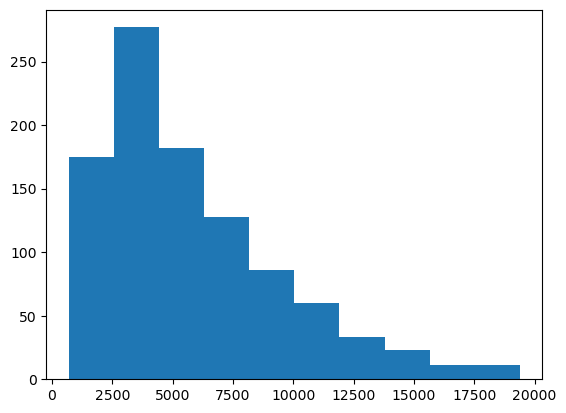

In [5]:
plt.hist(first_tx)

In [6]:

# plt.plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined_noise.T,0),'k--')

# backwards

## Simulate Experiment w/ Stochastic Accumulator

First, simulate 10,000 trials of stochastic accumulator. 

Then, pre-generaterun over trials and categorize them as regular press, probe, etc.
Probes delivered on each trial according to gamma function. The following conditions will determine the outcomes of our experiments

1. If threshold is crossed and designated probe time is more than 200 milliseconds in the future, regular press
2. If threshold is crossed and designated probe time is less than 200 milliseconds in the future, FTI
3. Otherwise, split the data according to a threshold   


In [2]:
n_sims = 10000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
noise = np.random.randn(n_sims,tsteps)
# noise = cn.powerlaw_psd_gaussian(1.5, (n_sims,tsteps))

slopes = np.random.rand(n_sims,)*0.2 # slope

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.298 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment




for tt in range(tsteps-1):
    
    # Stochastic Accumulator & Pink Noise Accumulator
    deltaX = (I - k * X[:,tt])*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    # Linear Ballistic Accumulator
#     if tt < 1500: continue
#     deltaX =  slopes*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt]) >= B:
        X[np.where(X[:,tt]>=B),tt+1] = B
    
    

### Pre-generate and plot the probe distribution

(array([1.494e+03, 3.931e+03, 2.786e+03, 1.225e+03, 3.980e+02, 1.110e+02,
        4.000e+01, 1.200e+01, 1.000e+00, 2.000e+00]),
 array([ 2.15998513,  3.52847019,  4.89695525,  6.26544031,  7.63392537,
         9.00241043, 10.37089549, 11.73938055, 13.10786561, 14.47635067,
        15.84483573]),
 <BarContainer object of 10 artists>)

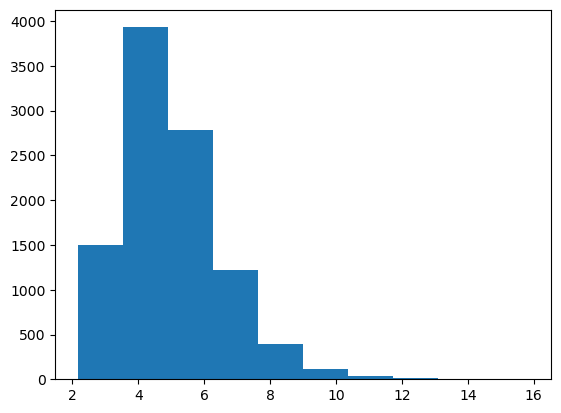

In [3]:
probes = np.random.gamma(4,0.75,n_sims)+2 # Gamma (used in experiment)
# probes = np.random.uniform(1,8,n_sims) # Uniform 1-8
# probes = np.random.normal(4,1,n_sims)

plt.hist(probes)

In [4]:
# Iterate over trials

time_before = 2500
time_after = 0
backwards = np.zeros((n_sims,time_before+time_after))
backwards_noise = np.zeros((n_sims,time_before+time_after))
condition = []
event_times = []
amplitudes = []
slopes = []

# Add on a delay for the metacognition
metacog_delay = 400

window = 100

for ii in range(n_sims):
    # For current simulation, extract time of first threshold-crossing and probe
    this_probe = probes[ii]*1000
    
    # Include a try-except block to handle when the threshold is never crossed
    try:
        this_tx = np.where(X[ii,:]>=B)[0][0]
    except:
        this_tx = tsteps

    
    # Categorize trial as probe trial, fti trial, or regular press trial
    if this_probe <= this_tx:
        this_event = this_probe
        
#         if this_tx - this_probe <= 400:
#             condition.append('fti')
#         else:
#             condition.append('probe')
        condition.append('probe')
#     elif this_probe - this_tx < 200:
#         this_event = this_probe
#         condition.append('fti')
    else:
        this_event = this_tx
        condition.append('reg')
     
    # Save the event time & amplitude
    event_times.append(this_event)
    amplitudes.append(X[ii,int(this_event + metacog_delay)])
#     slope = np.polyfit(np.arange(1,201),X[ii,int(this_event + metacog_delay):int(this_event+metacog_delay + 200)],1)
#         slopes.append(slope[0])

    result = linregress(np.arange(1,window+1), X[ii,int(this_event + metacog_delay):int(this_event+metacog_delay + window)])
    slopes.append(result.slope)
#     slopes.append((X[ii,int(this_event + metacog_delay + window)] - X[ii,int(this_event+metacog_delay)])/window)
    
    # If event occurs more than 3000 ms into trial, save the last 
    if (this_event > 3000) and (this_event < tsteps - time_after):
        backwards[ii,:] = X[ii,int(this_event-time_before):int(this_event + time_after)]
        backwards_noise[ii,:] = noise[ii,int(this_event-time_before):int(this_event + time_after)]
    else:
        backwards[ii,:] = np.nan
        backwards_noise[ii,:] = np.nan
    
    
# Make the data into a dataframe
df = pd.DataFrame({'type':condition,
                  'event_times':event_times,
                  'amplitudes':amplitudes,
                  'slopes':slopes})

df.type.value_counts(normalize=True)

probe    0.5019
reg      0.4981
Name: type, dtype: float64

In [5]:
# X[ii,int(this_event - time_before):int(this_event)].shape
this_event

6206

In [6]:
# Get the percentiles according to the data- actual ratio of miss:unsure:hit was 38.6:6.87:28.1, so turn those into percentiles

# pctl = [40.4,8.66,26.9]
pctl = [0.4,0.4,0.2]
pctl = np.cumsum(pctl/np.sum(pctl))*100
print(pctl)

[ 40.  80. 100.]


In [7]:
# get those percentiles from the condition column

amps_probe = df[df.type.str.match('probe')].amplitudes.values
slopes_probe = df[df.type.str.match('probe')].slopes.values


pMiss, pHit = np.percentile(amps_probe,pctl[0:2])
pMiss_slope, pHit_slope = np.percentile(slopes_probe,pctl[0:2])


print(pMiss,pHit)

pMed = np.nanmedian(df.loc[(df.type.str.match('probe')),'amplitudes'].values)

0.13710261481446934 0.23110562538521193


In [8]:
np.nanstd(slopes)

0.0002345793228458196

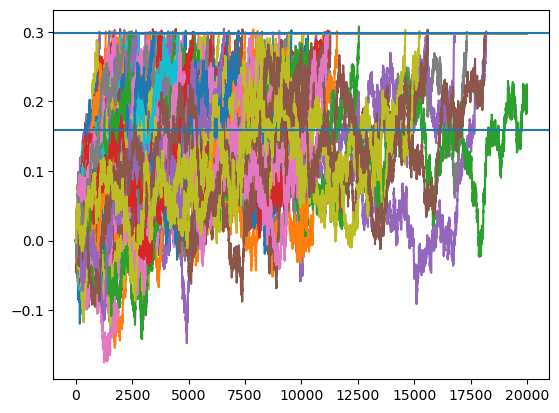

In [9]:
fig = plt.figure()

ax = plt.gca()

ax.plot(np.arange(tsteps),X[1:100,:].T)
ax.axhline(B)
ax.axhline(pMed)


plt.show()

# SAc Single-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\796882181.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\796882181.py:17: RuntimeWarning: Mean of empty slice
  back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)


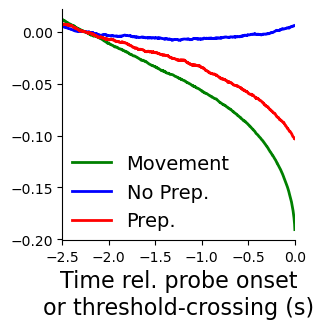

In [99]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values < pMiss),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values > pHit),'condition'] = 'hit'

# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)


# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/sac_singlestage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/sac_singlestage_400delay.png',bbox_inches='tight')

plt.show()



### Fitting Behavioral Data 

In [16]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(savepath+'modeling/supp_sac_singlestage_fti.svg',bbox_inches='tight')
# plt.savefig(savepath+'modeling/supp_sac_singlestage_fti.png',bbox_inches='tight')

plt.show()

PerfectSeparationError: Perfect separation detected, results not available

Optimization terminated successfully.
         Current function value: 0.676269
         Iterations 3
event_times    7.214724e-34
dtype: float64


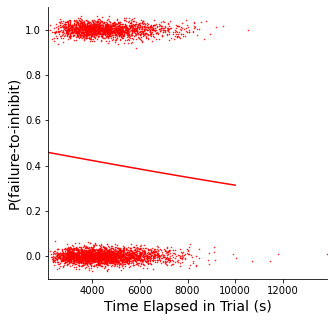

In [41]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(savepath+'modeling/supp_sac_singlestage_hit.svg',bbox_inches='tight')
# plt.savefig(savepath+'modeling/supp_sac_singlestage_hit.png',bbox_inches='tight')

plt.show()

## SAc Dual-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\415790887.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


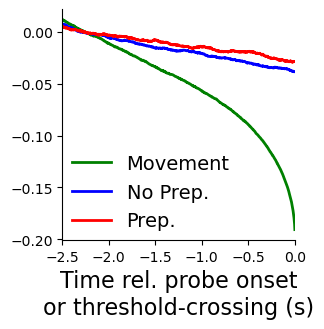

In [100]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.slopes.values < pMiss_slope),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.slopes.values > pHit_slope),'condition'] = 'hit'

# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/sac_dualstage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/sac_dualstage_400delay.png',bbox_inches='tight')

plt.show()



Optimization terminated successfully.
         Current function value: 0.193790
         Iterations 6
event_times    0.0
dtype: float64


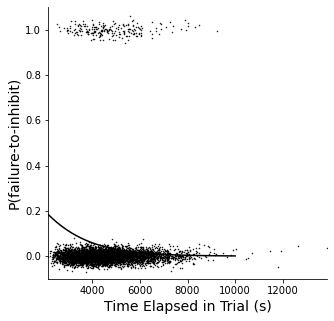

In [43]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_sac_dualstage_fti.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_sac_dualstage_fti.png',bbox_inches='tight')

plt.show()

Optimization terminated successfully.
         Current function value: 0.674782
         Iterations 3
event_times    1.280240e-36
dtype: float64


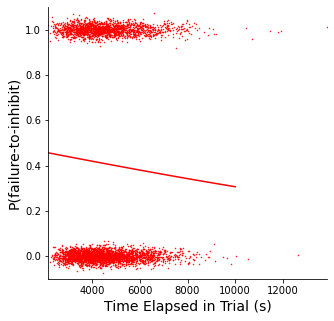

In [44]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_sac_dualstage_hit.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_sac_dualstage_hit.png',bbox_inches='tight')

plt.show()

In [112]:
np.random.rand(len(df)).shape

(10000,)

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\555430189.py:10: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


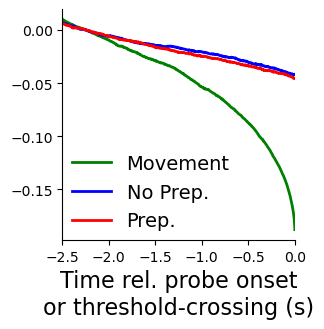

In [30]:
# Amplitudes based on percentiles

df['condition'] = 'miss'
df.loc[np.random.rand(len(df)) < 0.5,'condition'] = 'hit'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'


# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/sac_guess.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/sac_guess.png',bbox_inches='tight')

plt.show()

# Pink-Noise Accumulator

## Testing

In [31]:
n_sims = 1000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.random.randn(n_sims,tsteps)
noise = cn.powerlaw_psd_gaussian(1.5, (n_sims,tsteps))

slopes = np.random.rand(n_sims,)*0.2 # slope

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.298 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment




for tt in range(tsteps-1):
    
    # Stochastic Accumulator & Pink Noise Accumulator
    deltaX = (I - k * X[:,tt])*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    # Linear Ballistic Accumulator
#     if tt < 1500: continue
#     deltaX =  slopes*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt]) >= B:
        X[np.where(X[:,tt]>=B),tt+1] = B
    

In [32]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
            backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
            backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\2615556853.py:11: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\2615556853.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1


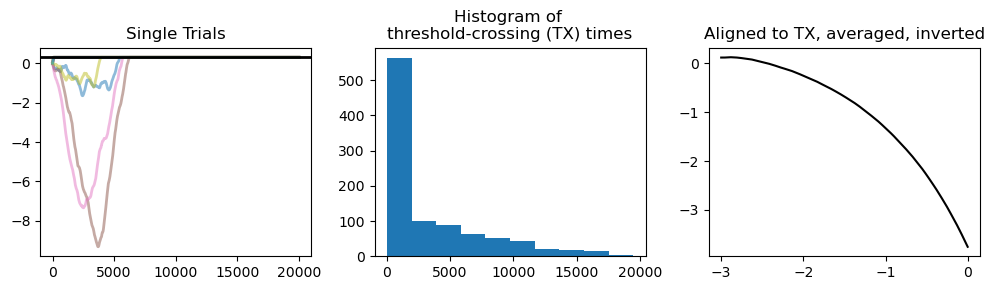

In [33]:
fig,ax = plt.subplots(1,3,figsize=(10,3))


ax[0].plot(np.arange(tsteps),X[:10,:].T,lw=2,alpha=0.5)
ax[0].axhline(B,color='k',lw=2)
ax[0].set_title('Single Trials')

ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')
fig.tight_layout()

# plt.savefig(savepath+'modeling/supp_pnac_runs.svg',bbox_inches='tight')
# plt.savefig(savepath+'modeling/supp_pnac_runs.png',bbox_inches='tight')

plt.show()

### Full Model

In [68]:
n_sims = 10000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.random.randn(n_sims,tsteps)
noise = cn.powerlaw_psd_gaussian(1.5, (n_sims,tsteps))

slopes = np.random.rand(n_sims,)*0.2 # slope

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
k = 0.5 # leak
I = 0.11 # urgency/drift
# I = 0.2
B = 0.298 # threshold
c = 0.1 # noise scaling
dt = 0.001 # time increment




for tt in range(tsteps-1):
    
    # Stochastic Accumulator & Pink Noise Accumulator
    deltaX = (I - k * X[:,tt])*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    # Linear Ballistic Accumulator
#     if tt < 1500: continue
#     deltaX =  slopes*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    

(array([ 835., 2842., 2944., 1868.,  907.,  381.,  144.,   53.,   19.,
           7.]),
 array([ 2.11381526,  3.20665577,  4.29949629,  5.39233681,  6.48517733,
         7.57801785,  8.67085837,  9.76369888, 10.8565394 , 11.94937992,
        13.04222044]),
 <BarContainer object of 10 artists>)

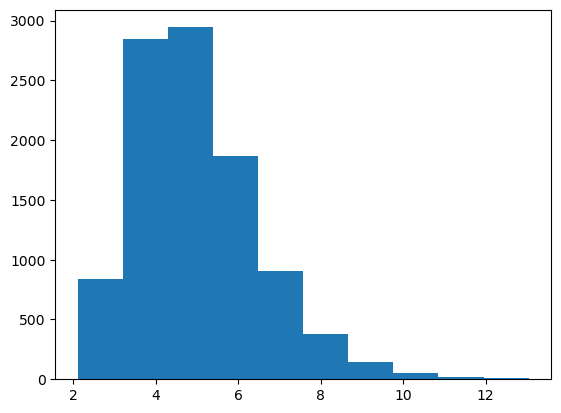

In [69]:
probes = np.random.gamma(4,0.75,n_sims)+2 # Gamma (used in experiment)
# probes = np.random.uniform(1,8,n_sims) # Uniform 1-8
# probes = np.random.normal(4,1,n_sims)

plt.hist(probes)

In [77]:
# Iterate over trials

time_before = 2500
time_after = 500
backwards = np.zeros((n_sims,time_before+time_after))
backwards_noise = np.zeros((n_sims,time_before+time_after))
condition = []
event_times = []
amplitudes = []
slopes = []

# Add on a delay for the metacognition
metacog_delay = 400
window = 100

for ii in range(n_sims):
    # For current simulation, extract time of first threshold-crossing and probe
    this_probe = probes[ii]*1000
    
    # Include a try-except block to handle when the threshold is never crossed
    try:
        this_tx = np.where(X[ii,:]>=B)[0][0]
    except:
        this_tx = tsteps

    
    # Categorize trial as probe trial, fti trial, or regular press trial
    if this_probe <= this_tx:
        this_event = this_probe
        
#         if this_tx - this_probe <= 400:
#             condition.append('fti')
#         else:
#             condition.append('probe')
        condition.append('probe')
#     elif this_probe - this_tx < 200:
#         this_event = this_probe
#         condition.append('fti')
    else:
        this_event = this_tx
        condition.append('reg')
     
    # Save the event time & amplitude
    event_times.append(this_event)
    amplitudes.append(X[ii,int(this_event + metacog_delay)])
#     slope = np.polyfit(np.arange(1,201),X[ii,int(this_event + metacog_delay):int(this_event+metacog_delay + 200)],1)
    result = linregress(np.arange(1,window+1), X[ii,int(this_event + metacog_delay):int(this_event+metacog_delay + window)])
    slopes.append(result.slope)
    
    # If event occurs more than 3000 ms into trial, save the last 
    if (this_event > 3000) and (this_event < tsteps - time_after):
        backwards[ii,:] = X[ii,int(this_event-time_before):int(this_event + time_after)]
        backwards_noise[ii,:] = noise[ii,int(this_event-time_before):int(this_event + time_after)]
    else:
        backwards[ii,:] = np.nan
        backwards_noise[ii,:] = np.nan
    
    
# Make the data into a dataframe
df = pd.DataFrame({'type':condition,
                  'event_times':event_times,
                  'amplitudes':amplitudes,
                  'slopes':slopes})

df.type.value_counts(normalize=True)

reg      0.7368
probe    0.2632
Name: type, dtype: float64

In [78]:
# Get the percentiles according to the data- actual ratio of miss:unsure:hit was 38.6:6.87:28.1, so turn those into percentiles

# pctl = [40.4,8.66,26.9]
pctl = [0.4,0.4,0.2]
pctl = np.cumsum(pctl/np.sum(pctl))*100
print(pctl)

[ 40.  80. 100.]


In [79]:
# get those percentiles from the condition column

amps_probe = df[df.type.str.match('probe')].amplitudes.values
slopes_probe = df[df.type.str.match('probe')].slopes.values


pMiss, pHit = np.percentile(amps_probe,pctl[0:2])
pMiss_slope, pHit_slope = np.percentile(slopes_probe,pctl[0:2])


print(pMiss,pHit)

pMed = np.nanmedian(df.loc[(df.type.str.match('probe')),'amplitudes'].values)

-4.3907756908061275 -1.2254981766274484


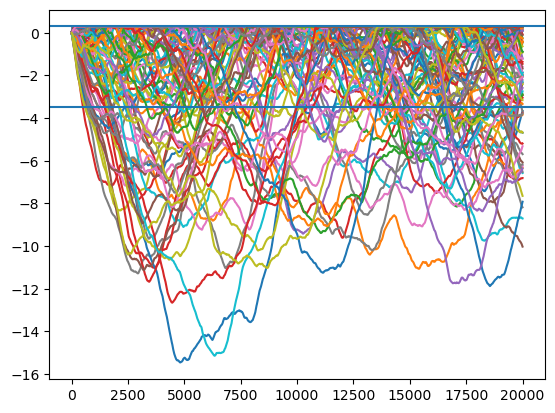

In [80]:
fig = plt.figure()

ax = plt.gca()

ax.plot(np.arange(tsteps),X[1:100,:].T)
ax.axhline(B)
ax.axhline(pMed)


plt.show()

# PNAc Single-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\4236242528.py:13: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T


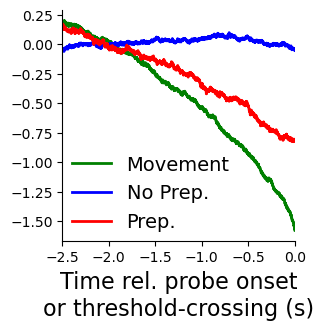

In [81]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values < pMiss),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values > pHit),'condition'] = 'hit'

# Split the backwards-facing data 
# backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)


# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/pnac_singlestage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/pnac_singlestage_400delay.png',bbox_inches='tight')

plt.show()



### Fitting Behavioral Data 

In [26]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_pnac_singlestage_fti.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_pnac_singlestage_fti.png',bbox_inches='tight')

plt.show()

PerfectSeparationError: Perfect separation detected, results not available

In [ ]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_pnac_singlestage_hit.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_pnac_singlestage_hit.png',bbox_inches='tight')

plt.show()

## PNAc Dual-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\1947069675.py:13: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T


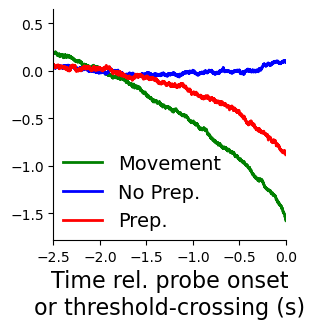

In [82]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.slopes.values < pMiss_slope),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.slopes.values > pHit_slope),'condition'] = 'hit'

# Split the backwards-facing data 
# backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)


# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/pnac_dualstage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/pnac_dualstage_400delay.png',bbox_inches='tight')

plt.show()



Optimization terminated successfully.
         Current function value: 0.155910
         Iterations 7
event_times    3.144539e-188
dtype: float64


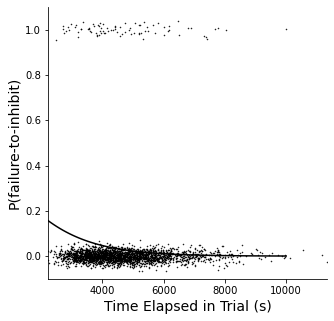

In [56]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_pnac_dualstage_fti.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_pnac_dualstage_fti.png',bbox_inches='tight')

plt.show()

Optimization terminated successfully.
         Current function value: 0.671840
         Iterations 3
event_times    1.516087e-21
dtype: float64


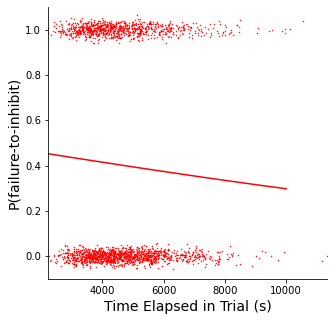

In [57]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_pnac_dualstage_hit.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_pnac_dualstage_hit.png',bbox_inches='tight')

plt.show()

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\2906434316.py:13: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T


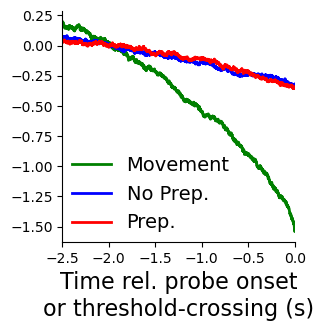

In [48]:
# Guessing

# Amplitudes based on percentiles

df['condition'] = 'miss'
df.loc[np.random.rand(len(df)) < 0.5,'condition'] = 'hit'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'


# Split the backwards-facing data 
# backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

# plt.savefig(savepath+'modeling/pnac_guess.svg',bbox_inches='tight')
# plt.savefig(savepath+'modeling/pnac_guess.png',bbox_inches='tight')

plt.show()

## Linear Ballistic Accumulator Basics

In [43]:
# Simulation basics
n_sims = 1000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)
# noise = np.random.randn(n_sims,tsteps) # white noise

# slopes = np.abs(np.random.randn(n_sims,)*3 + 4/3) # slope
# slopes = np.random.randn(n_sims,)*0.8 + 2.5 # slope
slopes = np.random.randn(n_sims,)*1+2


# Pink noise


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)

B = 6000 # threshold
dt = 1


X[:,0] = np.random.rand(n_sims,) * 4000

for tt in range(tsteps-1):
    
    if tt < 2500:
        X[:,tt+1] = X[:,tt]
        continue
    deltaX =  slopes*dt #+ c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    
    
    
X[np.where(X>=B)] = B
    

In [44]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
#             backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
#             backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_20304/2375877803.py:11: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1


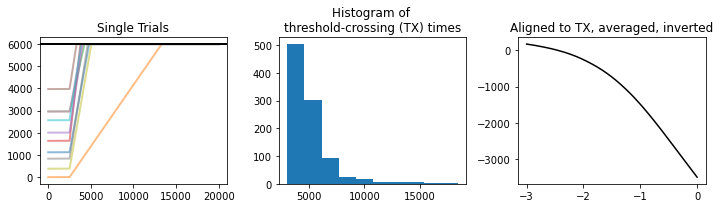

In [45]:
fig,ax = plt.subplots(1,3,figsize=(10,3))


ax[0].plot(np.arange(tsteps),X[:10,:].T,lw=2,alpha=0.5)
ax[0].axhline(B,color='k',lw=2)
ax[0].set_title('Single Trials')

ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')
fig.tight_layout()

plt.savefig(savepath+'modeling/supp_lbac_runs.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_lbac_runs.png',bbox_inches='tight')

plt.show()

(array([  8.,  26.,  77., 199., 256., 244., 138.,  42.,   9.,   1.]),
 array([-5.57231694, -4.19212567, -2.81193439, -1.43174312, -0.05155185,
         1.32863942,  2.70883069,  4.08902196,  5.46921323,  6.8494045 ,
         8.22959577]),
 <BarContainer object of 10 artists>)

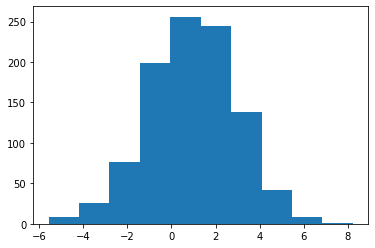

In [59]:
plt.hist(slopes)

## Full LBA Sim w/ no noise

In [49]:
n_sims = 10000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.random.randn(n_sims,tsteps)
noise = cn.powerlaw_psd_gaussian(1.5, (n_sims,tsteps))

# slopes = np.abs(np.random.randn(n_sims,)*3 + 4/3) # slope
# slopes = np.random.randn(n_sims,)*0.8 + 2.5 # slope
slopes = np.random.randn(n_sims,) * 1 + 2

# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)
B = 6000 # threshold
dt = 1


X[:,0] = np.random.rand(n_sims,) * 4000


for tt in range(tsteps-1):
    
    # Stochastic Accumulator & Pink Noise Accumulator
#     deltaX = (I - k * X[:,tt])*dt + c * noise[:,tt] * np.sqrt(dt) 
    
    # Linear Ballistic Accumulator
    if tt < 2500:
        X[:,tt+1] = X[:,tt]
        continue
    deltaX =  slopes*dt #+ c * noise[:,tt] * np.sqrt(dt) 
    
    X[:,tt+1] = X[:,tt] + deltaX
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    

In [62]:
# Iterate over trials

time_before = 2500
time_after = 500
backwards = np.zeros((n_sims,2500))
backwards_noise = np.zeros((n_sims,2500))
condition = []
event_times = []
amplitudes = []
slopes = []

probes = np.random.gamma(4,0.75,n_sims)+2 # Gamma (used in experiment)

metacog_delay = 400
window = 100

for ii in range(n_sims):
    # For current simulation, extract time of first threshold-crossing and probe
    this_probe = probes[ii]*1000
    
    # Include a try-except block to handle when the threshold is never crossed
    try:
        this_tx = np.where(X[ii,:]>=B)[0][0]
    except:
        this_tx = tsteps

    
    # Categorize trial as probe trial, fti trial, or regular press trial
    if this_probe <= this_tx:
        this_event = this_probe
        
#         if this_tx - this_probe <= 400:
#             condition.append('fti')
#         else:
#             condition.append('probe')
        condition.append('probe')
#     elif this_probe - this_tx < 200:
#         this_event = this_probe
#         condition.append('fti')
    else:
        this_event = this_tx
        condition.append('reg')
     
    # Save the event time & amplitude
    event_times.append(this_event)
    amplitudes.append(X[ii,int(this_event + metacog_delay)])
#     slope = np.polyfit(np.arange(1,201),X[ii,int(this_event):int(this_event+200)],1)
    result = linregress(np.arange(1,window+1), X[ii,int(this_event + metacog_delay):int(this_event+metacog_delay + window)])
    slopes.append(result.slope)
    
    # If event occurs more than 3000 ms into trial, save the last 
    if this_event > 3000:
        backwards[ii,:] = X[ii,int(this_event-2500):int(this_event)]
        backwards_noise[ii,:] = noise[ii,int(this_event-2500):int(this_event)]
    else:
        backwards[ii,:] = np.nan
        backwards_noise[ii,:] = np.nan
    
    
# Make the data into a dataframe
df = pd.DataFrame({'type':condition,
                  'event_times':event_times,
                  'amplitudes':amplitudes,
                  'slopes':slopes})

df.type.value_counts(normalize=True)

reg      0.5085
probe    0.4915
Name: type, dtype: float64

In [63]:
# Get the percentiles according to the data- actual ratio of miss:unsure:hit was 38.6:6.87:28.1, so turn those into percentiles

# pctl = [40.4,8.66,26.9]
pctl = [0.4,0.4,0.2]
pctl = np.cumsum(pctl/np.sum(pctl))*100
print(pctl)

# get those percentiles from the condition column

amps_probe = df[df.type.str.match('probe')].amplitudes.values
slopes_probe = df[df.type.str.match('probe')].slopes.values


pMiss, pHit = np.percentile(amps_probe,pctl[0:2])
pMiss_slope, pHit_slope = np.percentile(slopes_probe,pctl[0:2])


print(pMiss,pHit)

pMed = np.nanmedian(df.loc[(df.type.str.match('probe')),'amplitudes'].values)

[ 40.  80. 100.]
4091.960371869592 5884.231698955112


In [64]:
# get those percentiles from the condition column

amps_probe = df[df.type.str.match('probe')].amplitudes.values
slopes_probe = df[df.type.str.match('probe')].slopes.values


pMiss, pHit = np.percentile(amps_probe,pctl[0:2])
pMiss_slope, pHit_slope = np.percentile(slopes_probe,pctl[0:2])


print(pMiss,pHit)

pMed = np.nanmedian(df.loc[(df.type.str.match('probe')),'amplitudes'].values)

4091.960371869592 5884.231698955112


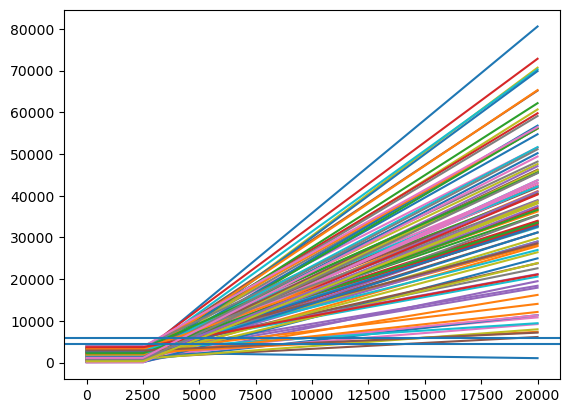

In [65]:
fig = plt.figure()

ax = plt.gca()

ax.plot(np.arange(tsteps),X[1:100,:].T)
ax.axhline(B)
ax.axhline(pMed)


plt.show()

# LBAc Single-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\2111642644.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


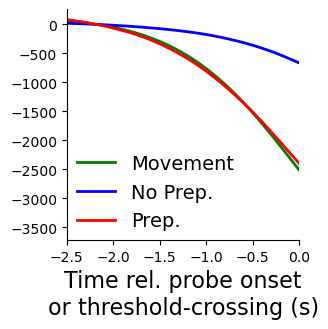

In [66]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values < pMiss),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.amplitudes.values > pHit),'condition'] = 'hit'

# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)


# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/lbac_singlestage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/lbac_singlestage_400delay.png',bbox_inches='tight')

plt.show()

### Fitting Behavioral Data 

In [19]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_lbac_singlestage_fti.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_lbac_singlestage_fti.png',bbox_inches='tight')

plt.show()

PerfectSeparationError: Perfect separation detected, results not available

In [ ]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_lbac_singlestage_hit.svg')
plt.savefig(savepath+'modeling/supp_sac_singlestage_hit.png')

plt.show()

## LBAc Dual-Stage Metacognitive Model

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\936081655.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


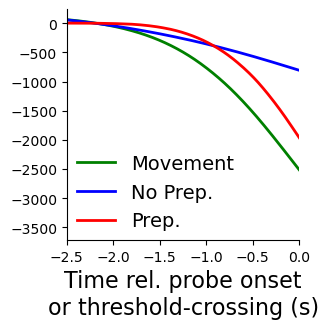

In [67]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.slopes.values < pMiss_slope),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.slopes.values > pHit_slope),'condition'] = 'hit'

# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)
# ax.set_yticks([])

plt.savefig(savepath+'modeling/lbac_dualstage_400delay.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/lbac_dualstage_400delay.png',bbox_inches='tight')

plt.show()



In [21]:
## FTI Trials

df_temp = df[~(df.condition.isin(['reg'])) & (df.event_times > 0)].copy()
df_temp['isfti'] = df_temp.condition.str.match('fti').astype('int')

logit = sm.Logit(df_temp['isfti'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_fti = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_fti,'-k')

ax.plot(df_temp.event_times.values,df_temp.isfti.values+np.random.randn(df_temp.isfti.values.shape[0])*0.02,'.k',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_lbac_dualstage_fti.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_lbac_dualstage_fti.png',bbox_inches='tight')

plt.show()

PerfectSeparationError: Perfect separation detected, results not available

Optimization terminated successfully.
         Current function value: 0.591936
         Iterations 4
event_times    3.015362e-157
dtype: float64


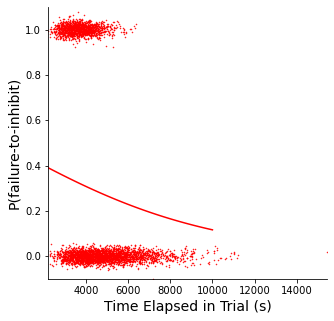

In [22]:
df_temp = df[~(df.condition.isin(['reg','fti','unsure'])) & (df.event_times > 0)].copy()
df_temp['ishit'] = df_temp.condition.str.match('hit').astype('int')

logit = sm.Logit(df_temp['ishit'],df_temp['event_times']).fit()
print(logit.pvalues)
times = np.linspace(0,10000,100)
probs_hit = logit.predict(times)

fig = plt.figure(figsize=(5,5))

ax = plt.gca()

ax.plot(times,probs_hit,'-r')

ax.plot(df_temp.event_times.values,df_temp.ishit.values+np.random.randn(df_temp.ishit.values.shape[0])*0.02,'.r',markersize=1)
# ax.plot(np.arange(tsteps),dist_from_threshold,'-b')
# ax.axvline(np.nanmin(df.event_times.values))
# ax.axvline(np.nanmax(df.event_times.values))

ax.set_ylim(-0.1,1.1)
ax.set_xlim(np.nanmin(df_temp.event_times.values)-0.1,np.nanmax(df_temp.event_times.values)+0.1)
ax.set_ylabel('P(failure-to-inhibit)',fontsize=14)
ax.set_xlabel('Time Elapsed in Trial (s)',fontsize=14)

# ax.annotate(f"P = {model.coefs['P-val'][1]:.3f}",(3 ,0.8),fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(savepath+'modeling/supp_lbac_dualstage_hit.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_lbac_dualstage_hit.png',bbox_inches='tight')

plt.show()

C:\Users\j_gav\AppData\Local\Temp\ipykernel_14076\180193281.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


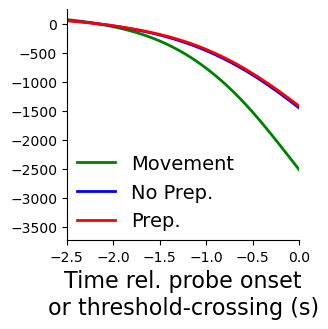

In [55]:
# Guessing

# Amplitudes based on percentiles

df['condition'] = 'miss'
df.loc[np.random.rand(len(df)) < 0.5,'condition'] = 'hit'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'


# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/lbac_guess.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/lbac_guess.png',bbox_inches='tight')

plt.show()

# Classic RP Simulation

## Basics/Testing

In [31]:
# Simulation basics
n_sims = 1000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)
# noise = np.random.randn(n_sims,tsteps) # white noise


# Create matrix of slopes (for now)
# slopes = np.ones((n_sims,tsteps))
slopes = np.random.rand(n_sims,tsteps) + 0.25
tOn = np.random.gamma(4,1,n_sims)*1000 +500 # Gamma (used in experiment)

tOn_binary = np.zeros((n_sims,tsteps))
for ii in range(n_sims):
    tOn_binary[ii,tOn[ii].astype('int'):] = 1

slopes_binary = slopes * tOn_binary


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)

B = 4/3# threshold
dt = 0.001




for tt in range(tsteps-1):
    
    
    deltaX =  slopes_binary[:,tt]*dt + np.random.randn(n_sims,) * 0 # last term is additive noise
    
    X[:,tt+1] = X[:,tt] + deltaX +  np.random.randn(n_sims,) *0.005 # white noise
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    
    
    
X[np.where(X>=B)] = B
    

In [32]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
#             backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
#             backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_78597/2167382416.py:11: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1


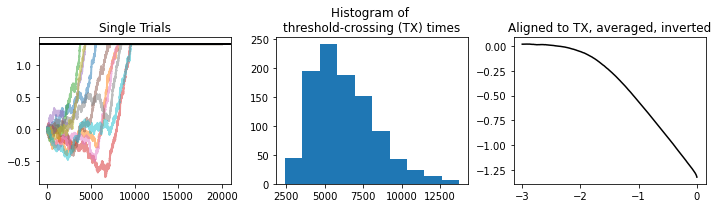

In [85]:


fig,ax = plt.subplots(1,3,figsize=(10,3))


ax[0].plot(np.arange(tsteps),X[:10,:].T,lw=2,alpha=0.5)
ax[0].axhline(B,color='k',lw=2)
ax[0].set_title('Single Trials')

ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')
fig.tight_layout()

plt.savefig(savepath+'modeling/supp_classic_runs.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_classic_runs.png',bbox_inches='tight')

plt.show()

# Full Classical Model Simulation 

In [33]:
n_sims = 10000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)
# noise = np.random.randn(n_sims,tsteps) # white noise


# Create matrix of slopes (for now)
# slopes = np.ones((n_sims,tsteps))
slopes = np.random.rand(n_sims,tsteps) + 0.25
tOn = np.random.gamma(4,1,n_sims)*1000 +1000 # Gamma (used in experiment)

tOn_binary = np.zeros((n_sims,tsteps))
for ii in range(n_sims):
    tOn_binary[ii,tOn[ii].astype('int'):] = 1

slopes_binary = slopes * tOn_binary


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)

B = 4# threshold
dt = 0.003




for tt in range(tsteps-1):
    
    
    deltaX =  slopes_binary[:,tt]*dt + np.random.randn(n_sims,) * 0 # last term is additive noise
    
    X[:,tt+1] = X[:,tt] + deltaX +  np.random.randn(n_sims,) *0.005 # white noise
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    
    
X[np.where(X>=B)] = B
    
    

In [34]:
# Iterate over trials
backwards = np.zeros((n_sims,2500))
backwards_noise = np.zeros((n_sims,2500))
condition = []
event_times = []
amplitudes = []

probes = np.random.gamma(4,0.75,n_sims)+2 # Gamma (used in experiment)


for ii in range(n_sims):
    # For current simulation, extract time of first threshold-crossing and probe
    this_probe = probes[ii]*1000
    
    # Include a try-except block to handle when the threshold is never crossed
    try:
        this_tx = np.where(X[ii,:]>=B)[0][0]
    except:
        this_tx = tsteps

    
    # Categorize trial as probe trial, fti trial, or regular press trial
    if this_probe <= this_tx:
        this_event = this_probe
        
#         if this_tx - this_probe <= 400:
#             condition.append('fti')
#         else:
#             condition.append('probe')
        condition.append('probe')
#     elif this_probe - this_tx < 200:
#         this_event = this_probe
#         condition.append('fti')
    else:
        this_event = this_tx
        condition.append('reg')
     
    # Save the event time & amplitude
    event_times.append(this_event)
    
    
    
    # If event occurs more than 3000 ms into trial, save the last 
    if this_event > 3000:
        backwards[ii,:] = X[ii,int(this_event-2500):int(this_event)]
#         backwards_noise[ii,:] = noise[ii,int(this_event-2500):int(this_event)]
    else:
        backwards[ii,:] = np.nan
#         backwards_noise[ii,:] = np.nan
    
    
# Make the data into a dataframe
df = pd.DataFrame({'type':condition,
                  'event_times':event_times})

df.type.value_counts(normalize=True)

probe    0.7705
reg      0.2295
Name: type, dtype: float64

In [35]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.event_times.values < tOn),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.event_times.values > tOn),'condition'] = 'hit'

In [36]:
# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_74312/2105691900.py:2: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_74312/2105691900.py:7: RuntimeWarning: Mean of empty slice
  back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)


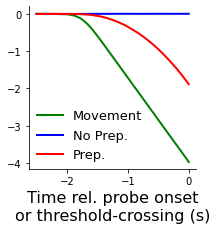

In [37]:
time = np.linspace(-2.5,0,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.2,fontsize=13)

ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/classic.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/classic.png',bbox_inches='tight')

plt.show()




/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_74312/2884770680.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


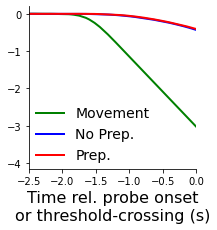

In [38]:
# Guessing

# Amplitudes based on percentiles

df['condition'] = 'miss'
df.loc[np.random.rand(len(df)) < 0.5,'condition'] = 'hit'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'


# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/classic_guess.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/classic_guess.png',bbox_inches='tight')

plt.show()

# Classic RP Simulation: Exponential Version

Where input to the RP is an exponential / quadratic buildup (attained by the vector of ones that is multiplied following $t_{on}$ increasing linearly rather than being constant ones).

## Basics/Testing

In [99]:
# Simulation basics
n_sims = 1000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)
# noise = np.random.randn(n_sims,tsteps) # white noise


# Create matrix of slopes (for now)
# slopes = np.ones((n_sims,tsteps))
slopes = (np.random.rand(n_sims,tsteps) + 0.25) * 0.001
tOn = np.random.gamma(4,1,n_sims)*1000 +500 # Gamma (used in experiment)

tOn_binary = np.zeros((n_sims,tsteps))
for ii in range(n_sims):
    
    shape2use = tOn_binary[ii,tOn[ii].astype('int'):].shape[0]
    tOn_binary[ii,tOn[ii].astype('int'):] = np.arange(1,shape2use+1)

slopes_binary = slopes * tOn_binary


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)

B = 4/3# threshold
dt = 0.001




for tt in range(tsteps-1):
    
    
    deltaX =  slopes_binary[:,tt]*dt + np.random.randn(n_sims,) * 0 # last term is additive noise
    
    X[:,tt+1] = X[:,tt] + deltaX +  np.random.randn(n_sims,) *0.005 # white noise
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    
    
    
X[np.where(X>=B)] = B
    

In [100]:
first_tx = np.zeros(n_sims)
backwards = np.zeros((n_sims,3000))
backwards_noise = np.zeros((n_sims,3000))

for ii in range(n_sims):
    if np.any(np.where(X[ii,:]>=B)):
        first_tx[ii] = np.where(X[ii,:]>=B)[0][0]
        
        if first_tx[ii] > 3000:
            backwards[ii,:] = X[ii,int(first_tx[ii]-3000):int(first_tx[ii])]
#             backwards_noise[ii,:] = noise[ii,int(first_tx[ii]-3000):int(first_tx[ii])]

        else:
            backwards[ii,:] = np.nan
#             backwards_noise[ii,:] = np.nan
    else:
        first_tx[ii] = np.nan
        backwards[ii,:] = np.nan

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_78597/238034447.py:11: RuntimeWarning: Mean of empty slice
  backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1


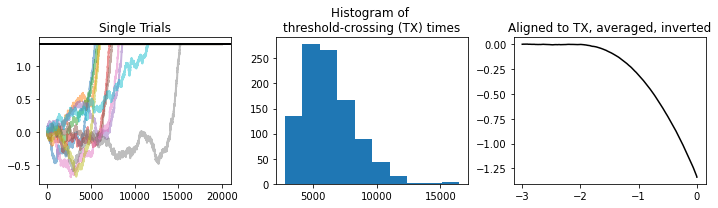

In [101]:


fig,ax = plt.subplots(1,3,figsize=(10,3))


ax[0].plot(np.arange(tsteps),X[:10,:].T,lw=2,alpha=0.5)
ax[0].axhline(B,color='k',lw=2)
ax[0].set_title('Single Trials')

ax[1].hist(first_tx)
ax[1].set_title('Histogram of \nthreshold-crossing (TX) times')

backwards_baselined = (backwards.T - np.nanmean(backwards[:,1:1000],1))*-1
backwards_baselined_noise = (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1))*-1
ax[2].plot(np.linspace(-3,0,backwards.shape[1]),np.nanmean(backwards_baselined.T,0),'k')
ax[2].set_title('Aligned to TX, averaged, inverted')

fig.tight_layout()

plt.savefig(savepath+'modeling/supp_classicExp_runs.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/supp_classicExp_runs.png',bbox_inches='tight')

plt.show()

# Full Classical RP-Exp Model Simulation 

In [39]:
n_sims = 10000
tsteps = 20000

X = np.zeros((n_sims,tsteps))
# noise = np.cumsum(np.random.randn(n_sims,tsteps),0)
# noise = np.random.randn(n_sims,tsteps) # white noise


# Create matrix of slopes (for now)
# slopes = np.ones((n_sims,tsteps))
slopes = (np.random.rand(n_sims,tsteps) + 0.25) * 0.001
tOn = np.random.gamma(4,1,n_sims)*1000 +500 # Gamma (used in experiment)

tOn_binary = np.zeros((n_sims,tsteps))
for ii in range(n_sims):
    
    shape2use = tOn_binary[ii,tOn[ii].astype('int'):].shape[0]
    tOn_binary[ii,tOn[ii].astype('int'):] = np.arange(1,shape2use+1)

slopes_binary = slopes * tOn_binary


# Simulation Parameters from Schurger, Sitt, & Dehaene (2012)

B = 4# threshold
dt = 0.003




for tt in range(tsteps-1):
    
    
    deltaX =  slopes_binary[:,tt]*dt + np.random.randn(n_sims,) * 0 # last term is additive noise
    
    X[:,tt+1] = X[:,tt] + deltaX +  np.random.randn(n_sims,) *0.005 # white noise
    
    # Stop updating if >= B
    if np.any(X[:,tt+1]) >= B:
        X[np.where(X[:,tt+1]>=B),tt+1] = B
    
    
    
X[np.where(X>=B)] = B
    
    

In [40]:
# Iterate over trials
backwards = np.zeros((n_sims,2500))
backwards_noise = np.zeros((n_sims,2500))
condition = []
event_times = []
amplitudes = []

probes = np.random.gamma(4,0.75,n_sims)+2 # Gamma (used in experiment)


for ii in range(n_sims):
    # For current simulation, extract time of first threshold-crossing and probe
    this_probe = probes[ii]*1000
    
    # Include a try-except block to handle when the threshold is never crossed
    try:
        this_tx = np.where(X[ii,:]>=B)[0][0]
    except:
        this_tx = tsteps

    
    # Categorize trial as probe trial, fti trial, or regular press trial
    if this_probe <= this_tx:
        this_event = this_probe
        
#         if this_tx - this_probe <= 400:
#             condition.append('fti')
#         else:
#             condition.append('probe')
        condition.append('probe')
#     elif this_probe - this_tx < 200:
#         this_event = this_probe
#         condition.append('fti')
    else:
        this_event = this_tx
        condition.append('reg')
     
    # Save the event time & amplitude
    event_times.append(this_event)
    
    
    
    # If event occurs more than 3000 ms into trial, save the last 
    if this_event > 3000:
        backwards[ii,:] = X[ii,int(this_event-2500):int(this_event)]
#         backwards_noise[ii,:] = noise[ii,int(this_event-2500):int(this_event)]
    else:
        backwards[ii,:] = np.nan
#         backwards_noise[ii,:] = np.nan
    
    
# Make the data into a dataframe
df = pd.DataFrame({'type':condition,
                  'event_times':event_times})

df.type.value_counts(normalize=True)

probe    0.7212
reg      0.2788
Name: type, dtype: float64

In [41]:
# Create new condition column
df.loc[df.type.str.match('probe'),'condition'] = 'unsure'
df['condition'] = 'unsure'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'

# Amplitudes based on percentiles
df.loc[(df.type.str.match('probe')) & (df.event_times.values < tOn),'condition'] = 'miss'
df.loc[(df.type.str.match('probe')) & (df.event_times.values > tOn),'condition'] = 'hit'

In [42]:
# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = backwards

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_74312/4194606784.py:2: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


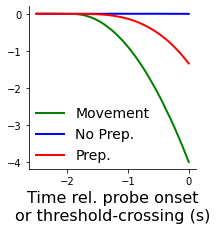

In [43]:
time = np.linspace(-2.5,0,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/classicExp.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/classicExp.png',bbox_inches='tight')

plt.show()




/var/folders/yf/4w_d87yd2839wcjcx53kmbn40000gn/T/ipykernel_74312/1428904413.py:12: RuntimeWarning: Mean of empty slice
  backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T


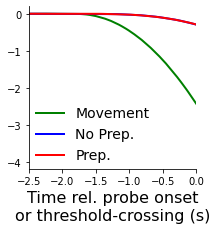

In [44]:
# Guessing

# Amplitudes based on percentiles

df['condition'] = 'miss'
df.loc[np.random.rand(len(df)) < 0.5,'condition'] = 'hit'
df.loc[df.type.str.match('reg'),'condition'] = 'reg'
df.loc[df.type.str.match('fti'),'condition'] = 'fti'


# Split the backwards-facing data 
backwards_baselined = -1 * (backwards.T - np.nanmean(backwards[:,1:500],1)).T
# backwards_baselined = -1 * (backwards_noise.T - np.nanmean(backwards_noise[:,1:1000],1)).T

back_hit = np.nanmean(backwards_baselined[(df.condition.str.match('hit')),:],0)
back_miss = np.nanmean(backwards_baselined[(df.condition.str.match('miss')),:],0)
# back_fti = np.nanmean(backwards_baselined[(df.condition.str.match('fti')),:],0)
back_reg = np.nanmean(backwards_baselined[(df.condition.str.match('reg')),:],0)
back_all = np.nanmean(backwards_baselined[(df.condition.isin(['hit','miss'])),:],0)

time = np.linspace(-time_before/1000,time_after/1000,backwards.shape[1])

fig = plt.figure(figsize=(3,3))
ax = plt.gca()


# ax.plot(time,back_fti,'k',label='FTI',lw=2)
ax.plot(time,back_reg,'g',label='Movement',lw=2)
ax.plot(time,back_miss,'b',label='No Prep.',lw=2)
ax.plot(time,back_hit,'r',label='Prep.',lw=2)

# ax.plot(time,back_all,'k--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower left',markerscale=2,frameon=False,facecolor='white',borderaxespad=0.1,fontsize=14)

ax.set_xlim(-2.5,0)
ax.set_xlabel('Time rel. probe onset\nor threshold-crossing (s)',fontsize=16)

plt.savefig(savepath+'modeling/classicExp_guess.svg',bbox_inches='tight')
plt.savefig(savepath+'modeling/classicExp_guess.png',bbox_inches='tight')

plt.show()